# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [2]:
import sys  
sys.path.insert(0, './model/')
import PredPrey as PP

uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]

#Define the Python model
py_model = Model('Python', function=PP.PredPrey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

In [3]:
processes = 10

## Linear regression on Prey

In [33]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
    experiments, outcomes = perform_experiments(py_model, 50, uncertainty_sampling=LHS)

### Look at final values of prey

#### Simple visuals

In [34]:
import pandas as pd

prey = pd.DataFrame(outcomes["prey"]).T

<Figure size 1440x720 with 0 Axes>

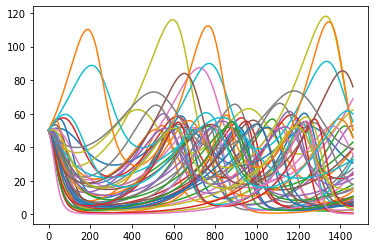

In [37]:
plt.figure(figsize=(20,10))
prey.plot(legend=None)
plt.show()

#### Better visuals

### Mean values of Prey

In [5]:
X = experiments[["predation_rate", "predator_efficiency", "predator_loss_rate", "prey_birth_rate"]]
Y = [i.mean() for i in outcomes["prey"]]

In [6]:
X = sm.add_constant(X)

In [7]:
mod = sm.OLS(Y, X).fit()

In [8]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     100.8
Date:                Tue, 04 May 2021   Prob (F-statistic):           7.38e-22
Time:                        00:20:54   Log-Likelihood:                -138.77
No. Observations:                  50   AIC:                             287.5
Df Residuals:                      45   BIC:                             297.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  25.5390      4.335      5.891      0.000      16.808      34.270
predation_rate        923.2928    832.605      1.109      0.273    -753.660    2600.246
predator_efficiency -1.186e+04    675.778    -17.556      0.000   -1.32e+04   -1.05e+04
predator_loss_rate    402.0968     51.425      7.819      0.000     298.522     505.671
prey_birth_rate       193.9039    105.914      1.831      0.074     -19.417     407.225
==============================================================================
Omnibus:                       11.008   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.847
Skew:                           1.078   Prob(JB):                      0.00441
Kurtosis:                       3.745   Cond. No.                     1.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='predation_rate'>

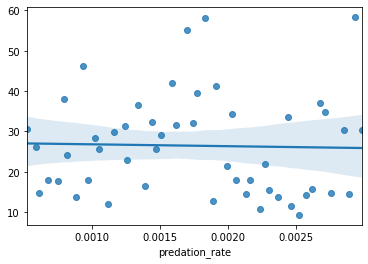

In [10]:
# U think he wants us to plot with statsmodels as well?
import seaborn as sns
sns.regplot(x=X["predation_rate"], y=Y)